In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Без этого я получаю ошибки с нехваткой ОЗУ :""D
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Папки для якорей, негативных и позитивных примеры
POS_PATH = os.path.join("data", "positive")  # Допускаемая персона, потверждённый класс 1
NEG_PATH = os.path.join("data", "negative")  # Не допускаемая персона, запрещающий класс 0
ANC_PATH = os.path.join("data", "anchor")  # Входные данные

In [5]:
# Создание самих папок (использовать один раз потом игнорировать)
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [6]:
# Распаковка датасета с лицами (один раз)
# import tarfile

# file = tarfile.open('lfw.tgz')
# file.extractall('./lfw')
# file.close()

In [7]:
# Перемещение данных в папку data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [8]:
# Библиотека для генерации названий для входных данных
import uuid

In [9]:
os.listdir("lfw")

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abbas_Kiarostami',
 'Abba_Eban',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_al-Attiyah',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullatif_Sener',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adelina_Avila',
 'Adel_Al-Jubeir',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adrien_Brody',
 'Afton_S

In [10]:
os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))

'data\\anchor\\3ea93c58-f3f7-11ee-ba0a-f56fede2168c.jpg'

In [11]:
# Подключение к камере и добавление кнопок (а) - Якоря (р) - Позитивные
# Кнопки задерживать
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    # Размер делаем 250x250px ибо фотки в датасете такого же формата
    frame = frame[120 : 120 + 250, 200 : 200 + 250, :]

    if cv2.waitKey(1) & 0xFF == ord("a"):
        imgname = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    if cv2.waitKey(1) & 0xFF == ord("p"):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    cv2.imshow("Image Collection", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

(250, 250, 3)

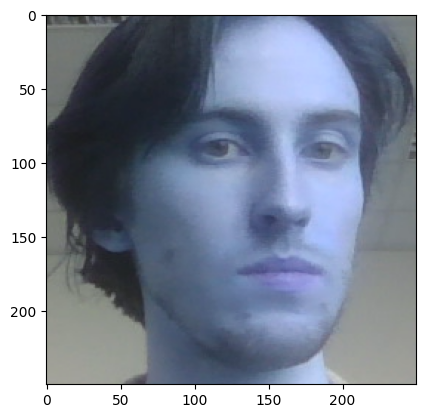

In [12]:
plt.imshow(frame)  # У OpenCV немного другой порядок канало, поэтому я и смурф :D
frame.shape

In [13]:
# Конвеер данных (число любое, но лучше что бы на каждый пример приходилось по 1м другому)
anchor = tf.data.Dataset.list_files(ANC_PATH + "\*.jpg").take(40)
positive = tf.data.Dataset.list_files(POS_PATH + "\*.jpg").take(40)
negative = tf.data.Dataset.list_files(NEG_PATH + "\*.jpg").take(40)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
# Проверка пути (я забываю какие слешы используются)
print(dir_test.next())

b'data\\anchor\\f7ab8d15-f27f-11ee-a5c9-002354425c4e.jpg'


In [16]:
def preprocess(file_path):
    # Читаем изображение
    byte_img = tf.io.read_file(file_path)
    # Декодируем из jpeg/jpg в uint8 тензор
    img = tf.io.decode_jpeg(byte_img)
    # Меняем размер на 100 пикселей и бьём на 3 канала
    img = tf.image.resize(img, (100, 100))
    # Маштабирование между 0 и 1
    img = img / 255.0
    return img

In [17]:
img = preprocess("data\\anchor\\cdb1fe43-f352-11ee-9345-002354425c4e.jpg")

In [18]:
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.93357843, 0.9218137 , 0.8865196 ],
        [0.9311274 , 0.9223039 , 0.8860294 ],
        [0.91862744, 0.91862744, 0.87941176],
        ...,
        [0.87916666, 0.88308823, 0.8281863 ],
        [0.8713235 , 0.8664216 , 0.8144608 ],
        [0.8745098 , 0.8666667 , 0.8156863 ]],

       [[0.935049  , 0.9223039 , 0.8870098 ],
        [0.93210787, 0.92034316, 0.88504905],
        [0.9372549 , 0.9262255 , 0.8887255 ],
        ...,
        [0.8752451 , 0.8723039 , 0.8281863 ],
        [0.87647057, 0.8691176 , 0.825     ],
        [0.8892157 , 0.88039213, 0.8362745 ]],

       [[0.93235296, 0.9166667 , 0.8813726 ],
        [0.9387255 , 0.9247549 , 0.8894608 ],
        [0.91789216, 0.90906864, 0.86495095],
        ...,
        [0.87647057, 0.8632353 , 0.8257353 ],
        [0.8568627 , 0.8480392 , 0.8039216 ],
        [0.87352943, 0.86470586, 0.82058823]],

       ...,

       [[0.12181372, 0.11985294, 0.12083333],
        [0.10

In [19]:
img.numpy().min()

0.008578432

In [20]:
img.numpy().max()

1.0

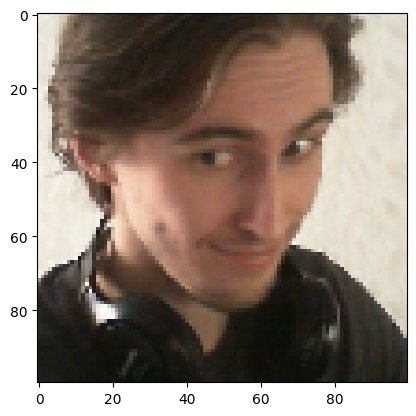

In [21]:
plt.imshow(img)

In [22]:
# Создаём наборы данных поситивных и негативных примеров

In [23]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [24]:
samples = data.as_numpy_iterator()

In [25]:
exampple = samples.next()

In [26]:
exampple

(b'data\\anchor\\cd81625e-f352-11ee-b613-002354425c4e.jpg',
 b'data\\positive\\a5f9c9ed-f352-11ee-8335-002354425c4e.jpg',
 1.0)

In [27]:
# Создание обучающего и тестового раздела

In [28]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [29]:
res = preprocess_twin(*exampple)

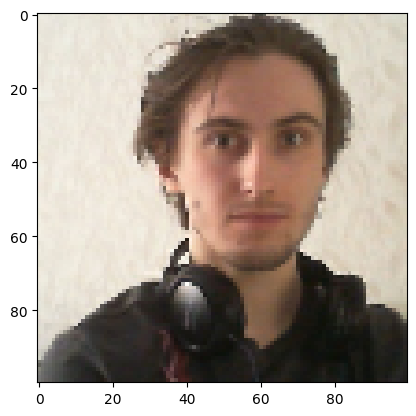

In [30]:
plt.imshow(res[1])

In [31]:
# Запускаем конвеер обработки данных
data = data.map(preprocess_twin)
data = data.cache()
# Перемешивание положительны и негативных данных
data = data.shuffle(buffer_size=1024)

In [32]:
# Пример того как нейронка будет получать размеченные данные

In [33]:
samples = data.as_numpy_iterator()

In [34]:
samp = samples.next()

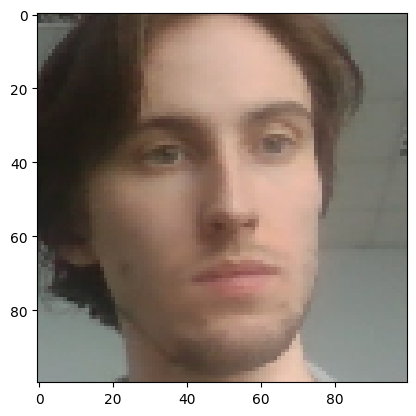

In [35]:
plt.imshow(samp[0])

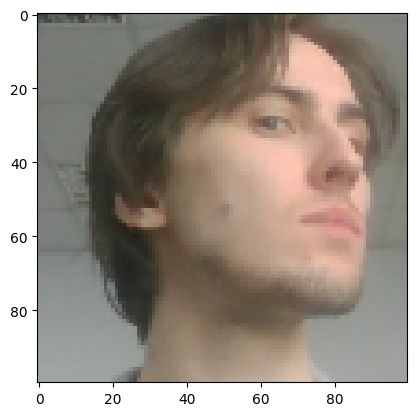

In [36]:
plt.imshow(samp[1])

In [37]:
samp[2]

1.0

In [38]:
# Тренирповочная секция
# берём 70% верных данных
train_data = data.take(round(len(data) * 0.7))
# Делаем батч на 16 изображений
train_data = train_data.batch(16)
# Предварительная выборка
train_data = train_data.prefetch(8)

In [39]:
# Тестовая секция
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [40]:
# Делаем модель

In [41]:
# Здесь я просто объявлял слои что бы отдельно их вызвать и посмотреть на их резы

# inp = Input(shape=(100,100,3), name='input_image')
# c1 = Conv2D(64, (10,10), activation='relu')(inp)
# m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
# c2 = Conv2D(128, (7,7), activation='relu')(m1)
# m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
# c3 = Conv2D(128, (4,4), activation='relu')(m2)
# m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
# c4 = Conv2D(256, (4,4), activation='relu')(m3)
# f1 = Flatten()(c4)
# d1 = Dense(4096, activation='sigmoid')(f1)

In [42]:
# mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [43]:
# m1

In [44]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name="input_image")

    # Первый блок
    # 64 фильтра размером 10х10
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    # Берём максимально значение в рамках 2х2 пикселей для сжатия
    m1 = MaxPooling2D(64, (2, 2), padding="same")(c1)

    # Второй блок
    # 128 фильтров размером 7х7
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)

    # Третий блок
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)

    # Реализуем финал сврёткой и плотным слоем
    # 256 фильтров стека 4х4
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    # Сглаживание из 3х в 1 измерение
    f1 = Flatten()(c4)
    # В итоге после слоя dense мы получаем вектор признаков
    d1 = Dense(4096, activation="sigmoid")(f1)

    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [45]:
embedding = make_embedding()

In [46]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [47]:
# Слой схожести (Чекаем насколько изображения схожи друг с другом)

In [48]:
class L1Dist(Layer):
    # Инициализации с наследованием
    def __init__(self, **kwargs):
        super().__init__()

    # Высчитывание разницы между входными (якорь) и проверочными данными
    def call(self, input_embedding, validation_embedding):
        # abs - возвращат абсолютное значеие
        return tf.math.abs(input_embedding - validation_embedding)

In [49]:
l1 = L1Dist()

In [50]:
l1

In [51]:
# Объединяем  всё под один капот

In [52]:
# input_image = Input(name='input_img', shape=(100,100,3))
# validation_image = Input(name='validation_img', shape=(100,100,3))

In [53]:
# inp_embedding = embedding(input_image)
# val_embedding = embedding(validation_image)

In [54]:
# siamese_layer = L1Dist()

In [55]:
# distances = siamese_layer(inp_embedding, val_embedding)

In [56]:
# classifier = Dense(1, activation='sigmoid')(distances)

In [57]:
# classifier

In [58]:
# siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [59]:
def make_siamese_model():

    # Якорь с вебки
    input_image = Input(name="input_img", shape=(100, 100, 3))

    # Проверочные данные в сетке
    validation_image = Input(name="validation_img", shape=(100, 100, 3))

    # Объединяем эмбединг с слоем схожести
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Слой классификации
    classifier = Dense(1, activation="sigmoid")(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")

In [60]:
siamese_model = make_siamese_model()

In [61]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [62]:
# Тренируем

In [63]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [64]:
opt = tf.keras.optimizers.Adam(1e-4)

In [65]:
# Установка пропускных пунктов

In [66]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [67]:
# Пошагавая функция обучения

In [68]:
# test_batch = train_data.as_numpy_iterator()

In [69]:
# batch_1 = test_batch.next()

In [70]:
# X = batch_1[:2]

In [71]:
# y = batch_1[2]

In [72]:
# y

In [73]:
# Декоратор требуется по документам
@tf.function
def train_step(batch):
    # Фиксируем все операции в сетке для получения градиентов
    with tf.GradientTape() as tape:
        # Получаем якоря и позитивные/негативные изображения
        X = batch[:2]
        # Вылавливаем метки
        y = batch[2]

        # Прямой проход
        yhat = siamese_model(X, training=True)
        # Высчитывание потерь
        loss = binary_cross_loss(y, yhat)
    print(loss)
    # Считаем градиент для различных обучаемых переменных
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # Высчитываем новые веса и применяем к моделе
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [74]:
# Делаем тренировочный луп

In [75]:
def train(data, EPOCHS):
    # Распечатка для просмотра эпох, метрик и т.д.
    for epoch in range(1, EPOCHS + 1):
        print("\n Epoch {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx + 1)
        # Сохранение чекпоинтов
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [76]:
# Тренируем модель

In [80]:
EPOCHS = 5

In [81]:
train(train_data, EPOCHS)


 Epoch 1/5
4/4 [==============================] - 129s 30s/step

 Epoch 2/5
4/4 [==============================] - 129s 31s/step

 Epoch 3/5
4/4 [==============================] - 150s 36s/step

 Epoch 4/5
4/4 [==============================] - 156s 37s/step

 Epoch 5/5
4/4 [==============================] - 160s 39s/step


In [82]:
# Оцениваем модель

In [83]:
from tensorflow.keras.metrics import Precision, Recall

In [84]:
# Пакет тестовых данных
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [85]:
# Предсказание (если + значит прошло, - не прошло)
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 8s 8s/step


array([[8.4024948e-01],
       [9.8251486e-01],
       [9.9831861e-01],
       [9.1694069e-01],
       [1.9055437e-01],
       [3.0985186e-04],
       [1.1222295e-03],
       [2.5292025e-05],
       [7.7452880e-01],
       [9.7518182e-01],
       [1.6743511e-02],
       [8.4478315e-03],
       [9.9325645e-01],
       [9.9519724e-01],
       [2.5797630e-02],
       [8.3215367e-05]], dtype=float32)

In [86]:
# Пост обработка результатов
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]

In [87]:
y_true

array([1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

In [88]:
# Вывод результатов в атомате по метрикам обучения
# Объект метрики
m = Recall()
# Подсчёт значений
m.update_state(y_true, y_hat)
# Возврат резов
m.result().numpy()

1.0

In [ ]:
# Визуализация результатов

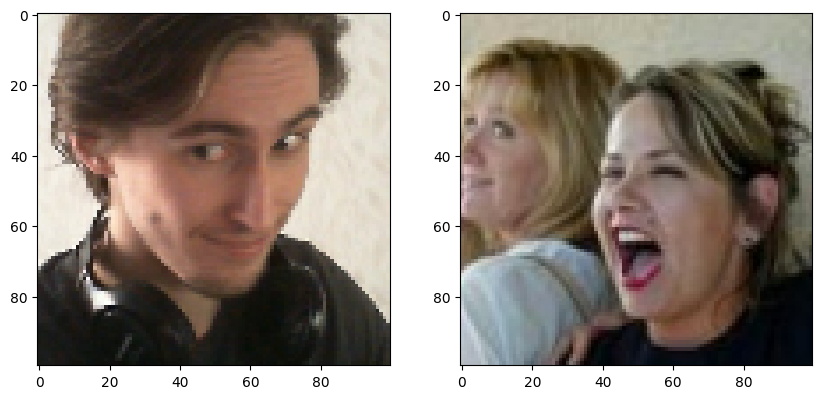

In [91]:
# Не забывать на результат y_true и вставлять нужный индекс
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[4])
plt.subplot(1, 2, 2)
plt.imshow(test_val[4])
plt.show()

In [ ]:
# Сохраняем модель

In [92]:
siamese_model.save("siamesemodel.h5")

In [93]:
L1Dist
model = tf.keras.models.load_model("siamesemodel.h5", custom_objects={"L1Dist": L1Dist, "BinaryCrossentropy": tf.losses.BinaryCrossentropy})

In [ ]:
# Тестируем в реальном времени

In [94]:
os.listdir(os.path.join("application_data", "verification_images"))

['ec0b2a57-f1db-11ee-a32e-002354425c4e.jpg']

In [95]:
os.path.join("application_data", "input_image", "input_image.jpg")

'application_data\\input_image\\input_image.jpg'

In [96]:
for image in os.listdir(os.path.join("application_data", "verification_images")):
    validation_img = os.path.join("application_data", "verification_images", image)
    print(validation_img)

application_data\verification_images\ec0b2a57-f1db-11ee-a32e-002354425c4e.jpg


In [99]:
def verify(model, detection_threshold, verification_threshold):
    # массив результатов
    results = []
    for image in os.listdir(os.path.join("application_data", "verification_images")):
        input_img = preprocess(os.path.join("application_data", "input_image", "input_image.jpg"))
        validation_img = preprocess(os.path.join("application_data", "verification_images", image))
        # Предсказание
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    # Верификация
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join("application_data", "verification_images")))
    verified = verification > verification_threshold

    return results, verified

In [ ]:
# Реальное время с камерой

In [103]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120 : 120 + 250, 200 : 200 + 250, :]
    cv2.imshow("Verification", frame)
    if cv2.waitKey(10) & 0xFF == ord("v"):
        cv2.imwrite(os.path.join("application_data", "input_image", "input_image.jpg"), frame)
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 459ms/step
True
1/1 [==============================] - 1s 541ms/step
True
1/1 [==============================] - 1s 507ms/step
True
1/1 [==============================] - 1s 523ms/step
True
1/1 [==============================] - 1s 554ms/step
True
1/1 [==============================] - 1s 599ms/step
True
1/1 [==============================] - 1s 593ms/step
True
1/1 [==============================] - 1s 569ms/step
True
1/1 [==============================] - 1s 644ms/step
True
1/1 [==============================] - 1s 558ms/step
True
1/1 [==============================] - 0s 417ms/step
False
1/1 [==============================] - 0s 486ms/step
False
1/1 [==============================] - 0s 478ms/step
False
1/1 [==============================] - 1s 543ms/step
False
1/1 [==============================] - 1s 614ms/step
False
1/1 [==============================] - 1s 508ms/step
False
1/1 [==============================] - 0s 456ms/step
False
1/1 [==